In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from numba import jit
from sklearn import metrics
import time
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [5]:
pd.set_option("display.max_columns", 500)

# upload data

In [6]:
folder_path = "../data/"
train_identity = pd.read_csv(f"{folder_path}train_identity.csv")
train_transaction = pd.read_csv(f"{folder_path}train_transaction.csv")
test_identity = pd.read_csv(f"{folder_path}test_identity.csv")
test_transaction = pd.read_csv(f"{folder_path}test_transaction.csv")
sub = pd.read_csv(f"{folder_path}sample_submission.csv")
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

In [18]:
sub

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


In [7]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
test_identity.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [9]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [10]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0

In [11]:
# some preprocessing of naming cols
rename_cols = dict()
for col in test.columns:
    if "-" in col:
        rename_cols[col] = col.replace("-", "_")
    else:
        rename_cols[col] = col

In [12]:
train = train.rename(rename_cols, axis=1)
test = test.rename(rename_cols, axis=1)

In [13]:
print(
    f"There are {train.isnull().any().sum()} columns in train dataset with at least one missing values."
)

There are 414 columns in train dataset with at least one missing values.


In [14]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
print(
    f"There are {len(one_value_cols)} columns in train dataset with one unique value: {one_value_cols}"
)
print(
    f"There are {len(one_value_cols_test)} columns in test dataset with one unique value: {one_value_cols_test}"
)

There are 0 columns in train dataset with one unique value: []
There are 1 columns in test dataset with one unique value: ['V107']


# EDA

In [15]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

## distribution of target

In [16]:
train["isFraud"].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

Text(0.5, 1.0, 'isFraud distribution')

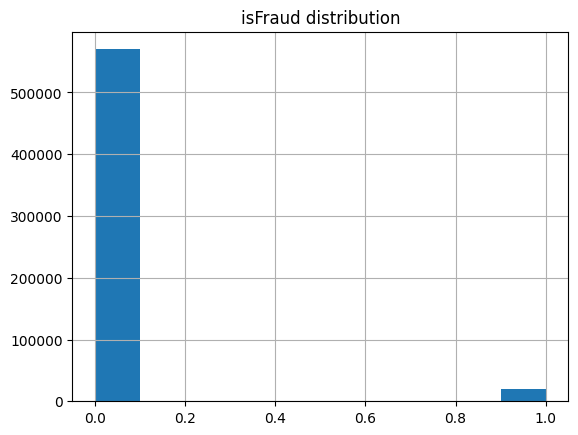

In [17]:
plt.hist(train["isFraud"])
plt.grid()
plt.title("isFraud distribution")

## check columns wich begining with "V"

In [23]:
V_col = [col for col in train.columns if col[0] == "V"]

In [24]:
cat_V_cols = []

In [25]:
for col in V_col:
    if len(train[col].unique()) < 10:
        print(col, len(train[col].unique()))
        cat_V_cols.append(col)

V1 3
V4 8
V5 8
V10 6
V11 7
V12 5
V13 8
V14 3
V15 9
V19 9
V21 7
V25 8
V27 5
V28 5
V29 7
V30 9
V31 9
V33 8
V35 5
V36 7
V41 3
V46 8
V48 7
V49 7
V50 7
V51 8
V53 7
V54 8
V57 8
V61 8
V63 9
V64 9
V65 3
V66 9
V68 4
V69 7
V70 8
V71 8
V73 9
V75 6
V76 8
V79 9
V82 9
V83 9
V84 9
V85 9
V88 3
V89 4
V90 7
V91 8
V92 9
V93 9
V94 4
V107 3
V108 9
V109 9
V110 9
V114 8
V115 8
V116 8
V117 5
V118 5
V119 5
V120 5
V121 5
V122 5
V141 7
V173 9
V194 9
V240 7
V241 6
V305 3


In [26]:
len(cat_V_cols)

72

Note: it is binary features

## check which beging with C and D

In [27]:
train[sorted(list(set(train.columns) - set(V_col)))].head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,DeviceInfo,DeviceType,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,isFraud
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.0,13.0,NaN,NaN,NaN,0.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,W,NaN,68.5,86400,2987000,315.0,87.0,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,gmail.com,W,NaN,29.0,86401,2987001,325.0,87.0,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,315.0,NaN,NaN,NaN,315.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T,T,M0,F,F,F,F,F,outlook.com,W,NaN,59.0,86469,2987002,330.0,87.0,4663,490.0,150.0,visa,166.0,debit,287.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,112.0,84.0,NaN,NaN,NaN,NaN,111.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,yahoo.com,W,NaN,50.0,86499,2987003,476.0,87.0,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMSUNG SM-G892A Build/NRD90M,mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail.com,H,NaN,50.0,86506,2987004,420.0,87.0,4497,514.0,150.0,mastercard,102.0,credit,NaN,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,0


In [28]:
C_col = [col for col in train.columns if col[0] == "C"]
D_col = [col for col in train.columns if col[0] == "D"]
D_col.remove("DeviceInfo")
D_col.remove("DeviceType")

In [29]:
cat_D_cols = []
for col in D_col:
    if len(train[col].unique()) < 10:
        print(col, len(train[col].unique()))
        cat_D_cols.append(col)

In [30]:
cat_C_cols = []
for col in C_col:
    if len(train[col].unique()) < 10:
        print(col, len(train[col].unique()))
        cat_C_cols.append(col)

In [31]:
train[sorted(list(set(train.columns) - set(V_col) - set(C_col) - set(D_col)))].head()

,DeviceInfo,DeviceType,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,isFraud
0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,W,NaN,68.5,86400,2987000,315.0,87.0,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,gmail.com,W,NaN,29.0,86401,2987001,325.0,87.0,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,T,T,T,M0,F,F,F,F,F,outlook.com,W,NaN,59.0,86469,2987002,330.0,87.0,4663,490.0,150.0,visa,166.0,debit,287.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,yahoo.com,W,NaN,50.0,86499,2987003,476.0,87.0,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,SAMSUNG SM-G892A Build/NRD90M,mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail.com,H,NaN,50.0,86506,2987004,420.0,87.0,4497,514.0,150.0,mastercard,102.0,credit,NaN,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,0


## check id_{}

In [32]:
ID_col = [col for col in train.columns if "id_" in col]

In [33]:
ID_col

['id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

In [122]:
cat_ID_cols

['id_04',
 'id_12',
 'id_15',
 'id_16',
 'id_18',
 'id_23',
 'id_24',
 'id_27',
 'id_28',
 'id_29',
 'id_32',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

In [34]:
cat_ID_cols = []
for col in ID_col:
    if len(train[col].unique()) < 20:
        print(col, len(train[col].unique()))
        cat_ID_cols.append(col)

id_04 16
id_12 3
id_15 4
id_16 3
id_18 19
id_23 4
id_24 13
id_27 3
id_28 3
id_29 3
id_32 5
id_34 5
id_35 3
id_36 3
id_37 3
id_38 3


In [36]:
train[
    sorted(
        list(set(train.columns) - set(V_col) - set(C_col) - set(D_col) - set(ID_col))
    )
].head()

,DeviceInfo,DeviceType,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,isFraud
0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,W,NaN,68.5,86400,2987000,315.0,87.0,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,0
1,NaN,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,gmail.com,W,NaN,29.0,86401,2987001,325.0,87.0,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,0
2,NaN,NaN,T,T,T,M0,F,F,F,F,F,outlook.com,W,NaN,59.0,86469,2987002,330.0,87.0,4663,490.0,150.0,visa,166.0,debit,287.0,NaN,0
3,NaN,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,yahoo.com,W,NaN,50.0,86499,2987003,476.0,87.0,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,0
4,SAMSUNG SM-G892A Build/NRD90M,mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail.com,H,NaN,50.0,86506,2987004,420.0,87.0,4497,514.0,150.0,mastercard,102.0,credit,NaN,NaN,0


## check M_col

In [37]:
M_col = [col for col in train.columns if col[0] == "M"]

In [38]:
M_col

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [39]:
cat_M_cols = []
for col in M_col:
    if len(train[col].unique()) < 10:
        print(col, len(train[col].unique()))
        cat_M_cols.append(col)

M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [40]:
train[
    sorted(
        list(
            set(train.columns)
            - set(V_col)
            - set(C_col)
            - set(D_col)
            - set(ID_col)
            - set(M_col)
        )
    )
].head()

,DeviceInfo,DeviceType,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,isFraud
0,NaN,NaN,NaN,W,NaN,68.5,86400,2987000,315.0,87.0,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,0
1,NaN,NaN,gmail.com,W,NaN,29.0,86401,2987001,325.0,87.0,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,0
2,NaN,NaN,outlook.com,W,NaN,59.0,86469,2987002,330.0,87.0,4663,490.0,150.0,visa,166.0,debit,287.0,NaN,0
3,NaN,NaN,yahoo.com,W,NaN,50.0,86499,2987003,476.0,87.0,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,0
4,SAMSUNG SM-G892A Build/NRD90M,mobile,gmail.com,H,NaN,50.0,86506,2987004,420.0,87.0,4497,514.0,150.0,mastercard,102.0,credit,NaN,NaN,0


In [41]:
##

In [42]:
train.card1.value_counts()

card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: count, Length: 13553, dtype: int64

In [43]:
train.card2.value_counts()

card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
388.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: count, Length: 500, dtype: int64

In [44]:
train.card3.value_counts()

card3
150.0    521287
185.0     56346
106.0      1571
144.0      1252
146.0      1252
          ...  
224.0         1
199.0         1
221.0         1
209.0         1
173.0         1
Name: count, Length: 114, dtype: int64

In [45]:
train.card4.value_counts()

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: count, dtype: int64

In [46]:
train.card5.value_counts()

card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
          ...  
221.0         1
167.0         1
115.0         1
165.0         1
234.0         1
Name: count, Length: 119, dtype: int64

In [47]:
train.card6.value_counts()

card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: count, dtype: int64

In [48]:
train.addr1.value_counts()

addr1
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
386.0        1
101.0        1
353.0        1
516.0        1
245.0        1
Name: count, Length: 332, dtype: int64

In [49]:
train.addr2.value_counts()

addr2
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
49.0         1
14.0         1
25.0         1
22.0         1
93.0         1
Name: count, Length: 74, dtype: int64

# Feature engingeering

## Ratio of transaction_amount to 

In [50]:
def make_ratio_features_tr_amt(data, card_num):
    data[f"TransactionAmt_to_std_card{card_num}"] = data[
        "TransactionAmt"
    ] / data.groupby([f"card{card_num}"])["TransactionAmt"].transform("std")
    data[f"TransactionAmt_to_mean_card{card_num}"] = data[
        "TransactionAmt"
    ] / data.groupby([f"card{card_num}"])["TransactionAmt"].transform("mean")
    return data


def make_ratio_features_time_Delta_from_last(data, D_num, card_num):
    data[f"D{D_num}_to_mean_card1"] = data[f"D{D_num}"] / train.groupby(
        [f"card{card_num}"]
    )[f"D{D_num}"].transform("mean")
    return data

In [51]:
for card_num in tqdm(range(1, 7)):
    # print(card_num)
    train = make_ratio_features_tr_amt(train, card_num)
    test = make_ratio_features_tr_amt(test, card_num)
    for D_num in tqdm(range(1, 16)):
        train = make_ratio_features_tr_amt(train, card_num)
        test = make_ratio_features_tr_amt(test, card_num)

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


## let's split email domain

In [52]:
train["P_emaildomain"]

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: P_emaildomain, Length: 590540, dtype: object

In [53]:
train[["P_emaildomain_1", "P_emaildomain_2", "P_emaildomain_3"]] = train[
    "P_emaildomain"
].str.split(".", expand=True)
train[["R_emaildomain_1", "R_emaildomain_2", "R_emaildomain_3"]] = train[
    "R_emaildomain"
].str.split(".", expand=True)
test[["P_emaildomain_1", "P_emaildomain_2", "P_emaildomain_3"]] = test[
    "P_emaildomain"
].str.split(".", expand=True)
test[["R_emaildomain_1", "R_emaildomain_2", "R_emaildomain_3"]] = test[
    "R_emaildomain"
].str.split(".", expand=True)

In [54]:
cat_cols = [
    "id_12",  # from info about data
    "id_13",
    "id_14",
    "id_15",
    "id_16",
    "id_17",
    "id_18",
    "id_19",
    "id_20",
    "id_21",
    "id_22",
    "id_23",
    "id_24",
    "id_25",
    "id_26",
    "id_27",
    "id_28",
    "id_29",
    "id_30",
    "id_31",
    "id_32",
    "id_33",
    "id_34",
    "id_35",
    "id_36",
    "id_37",
    "id_38",
    "DeviceType",
    "DeviceInfo",
    "ProductCD",
    "card4",
    "card6",
    "P_emaildomain",
    "R_emaildomain",
    "M1",
    "M2",
    "M3",
    "M4",
    "M5",
    "M6",
    "M7",
    "M8",
    "M9",
    "P_emaildomain_1",
    "P_emaildomain_2",
    "P_emaildomain_3",
    "R_emaildomain_1",
    "R_emaildomain_2",
    "R_emaildomain_3",
]

# for searching important features firstrly use LabelEncoder

In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

# Find top features by lightgbm

## Prepare data for modelling

In [57]:
many_null_cols = [
    col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9
]
many_null_cols_test = [
    col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9
]

In [58]:
big_top_value_cols = [
    col
    for col in train.columns
    if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9
]
big_top_value_cols_test = [
    col
    for col in test.columns
    if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9
]

In [59]:
cols_to_drop = list(
    set(
        many_null_cols
        + many_null_cols_test
        + big_top_value_cols
        + big_top_value_cols_test
        + one_value_cols
        + one_value_cols_test
    )
)
cols_to_drop.remove("isFraud")
len(cols_to_drop)

82

In [60]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [61]:
X = train.sort_values("TransactionDT").drop(
    ["isFraud", "TransactionDT", "TransactionID"], axis=1
)
y = train.sort_values("TransactionDT")["isFraud"]
# X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(["TransactionDT", "TransactionID"], axis=1)
del train
test = test[["TransactionDT", "TransactionID"]]

In [62]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)


# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

# try TimeSeriesSplit

In [63]:
from sklearn.model_selection import KFold, TimeSeriesSplit


n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)

In [ ]:
# Used code from notebook on kaggle
def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return "auc", fast_auc(y_true, y_pred), True


@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += 1 - y_i
        auc += y_i * nfalse
    auc /= nfalse * (n - nfalse)
    return auc


def train_model_classification(
    X,
    X_test,
    y,
    params,
    folds,
    model_type="lgb",
    eval_metric="auc",
    columns=None,
    plot_feature_importance=False,
    model=None,
    verbose=10000,
    early_stopping_rounds=200,
    n_estimators=50000,
    splits=None,
    n_folds=3,
    averaging="usual",
    n_jobs=-1,
):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.

    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type

    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]

    # to set up scoring parameters
    metrics_dict = {
        "auc": {
            "lgb_metric_name": eval_auc,
            "catboost_metric_name": "AUC",
            "sklearn_scoring_function": metrics.roc_auc_score,
        },
    }

    result_dict = {}
    if averaging == "usual":
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    elif averaging == "rank":
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()

    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f"Fold {fold_n + 1} started at {time.ctime()}")
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = (
                X[columns].iloc[train_index],
                X[columns].iloc[valid_index],
            )
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == "lgb":
            model: LGBMClassifier = lgb.LGBMClassifier(
                **params, n_estimators=n_estimators, n_jobs=n_jobs
            )
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric=metrics_dict[eval_metric]["lgb_metric_name"],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=early_stopping_rounds),
                    lgb.log_evaluation(verbose),
                ],
            )

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[
                :, 1
            ]

        if averaging == "usual":
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(
                metrics_dict[eval_metric]["sklearn_scoring_function"](
                    y_valid, y_pred_valid
                )
            )

            prediction += y_pred.reshape(-1, 1)

        elif averaging == "rank":
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(
                metrics_dict[eval_metric]["sklearn_scoring_function"](
                    y_valid, y_pred_valid
                )
            )

            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)

        if model_type == "lgb" and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat(
                [feature_importance, fold_importance], axis=0
            )

    prediction /= n_splits

    print(
        "CV mean score: {0:.4f}, std: {1:.4f}.".format(np.mean(scores), np.std(scores))
    )

    result_dict["oof"] = oof
    result_dict["prediction"] = prediction
    result_dict["scores"] = scores

    if model_type == "lgb":
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = (
                feature_importance[["feature", "importance"]]
                .groupby("feature")
                .mean()
                .sort_values(by="importance", ascending=False)[:50]
                .index
            )

            best_features = feature_importance.loc[
                feature_importance.feature.isin(cols)
            ]

            plt.figure(figsize=(16, 12))
            sns.barplot(
                x="importance",
                y="feature",
                data=best_features.sort_values(by="importance", ascending=False),
            )
            plt.title("LGB Features (avg over folds)")

            result_dict["feature_importance"] = feature_importance
            result_dict["top_columns"] = cols

    return result_dict

Fold 1 started at Sun Dec 15 14:52:51 2024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's auc: 0.998461	training's auc: 0.998461	valid_1's auc: 0.900239	valid_1's auc: 0.900239
Fold 2 started at Sun Dec 15 14:53:23 2024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[162]	training's auc: 0.991593	training's auc: 0.991593	valid_1's auc: 0.916425	valid_1's auc: 0.916425
Fold 3 started at Sun Dec 15 14:54:00 2024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[231]	training's auc: 0.991698	training's auc: 0.991698	valid_1's auc: 0.907886	valid_1's auc: 0.907886
Fold 4 started at Sun Dec 15 14:54:54 2024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[267]	training's auc: 0.989288	training's auc: 0.989288	valid_1's auc: 0.92922	valid_1's auc: 0.92922
Fold 5 started at Sun Dec 

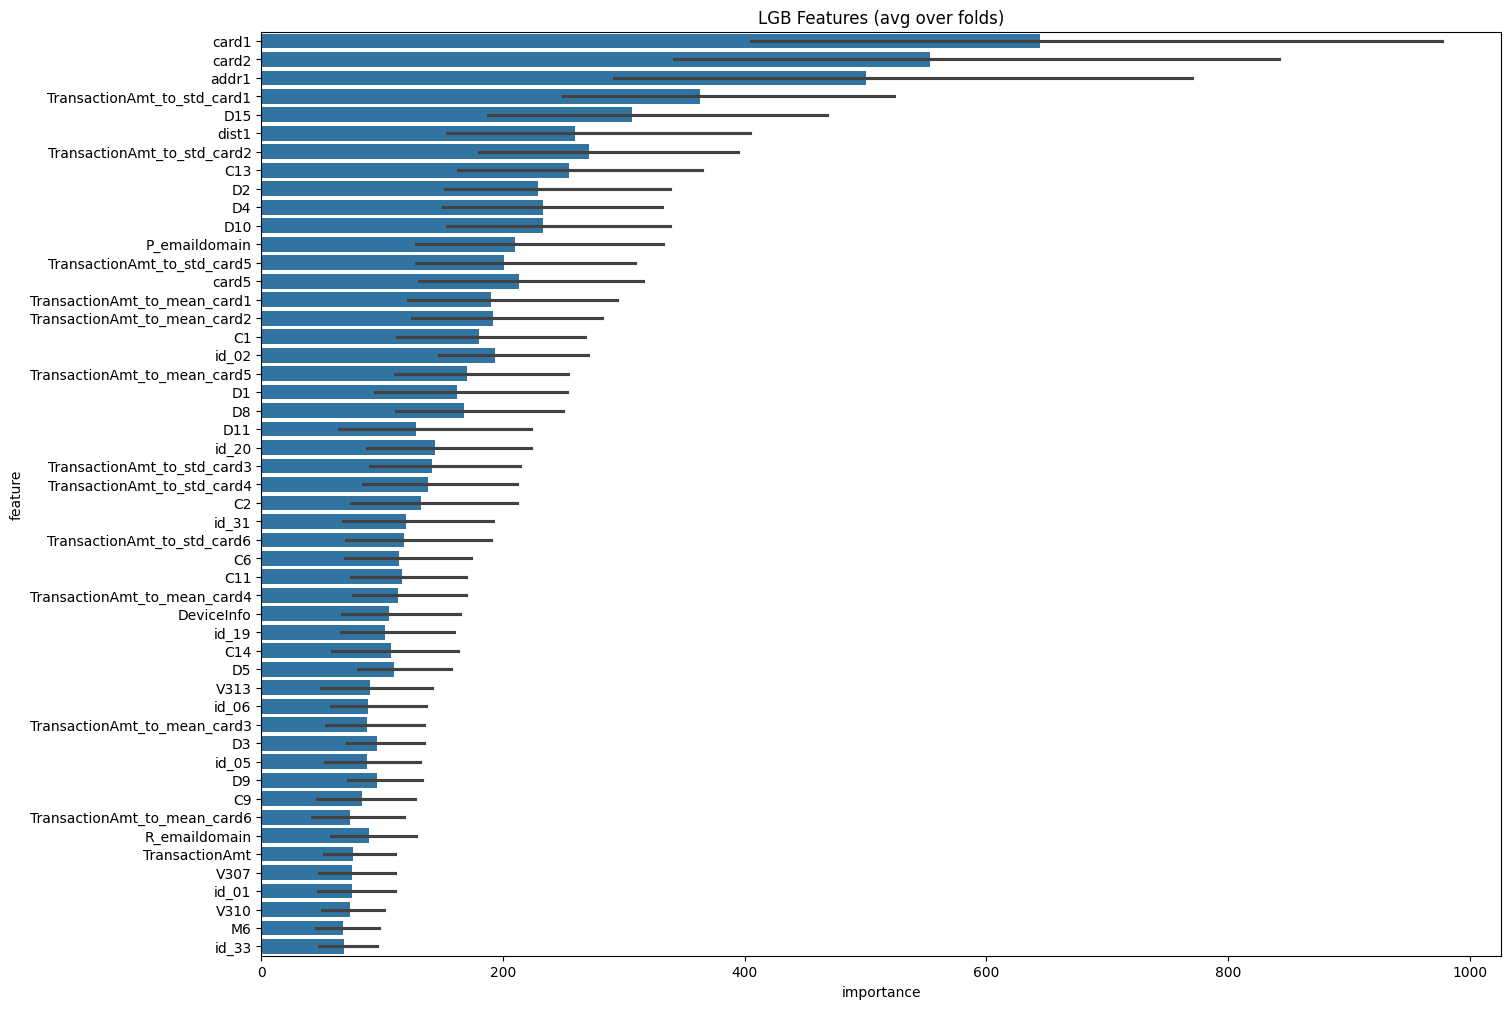

In [65]:
params = {
    "num_leaves": 256,
    "min_child_samples": 79,
    "objective": "binary",
    "max_depth": 13,
    "learning_rate": 0.03,
    "boosting_type": "gbdt",
    "subsample_freq": 3,
    "subsample": 0.9,
    "bagging_seed": 11,
    "metric": "auc",
    "verbosity": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.3,
    "colsample_bytree": 0.9,
    #'categorical_feature': cat_cols
}
result_dict_lgb_time_series = train_model_classification(
    X=X,
    X_test=X_test,
    y=y,
    params=params,
    folds=folds,
    model_type="lgb",
    eval_metric="auc",
    plot_feature_importance=True,
    verbose=500,
    early_stopping_rounds=200,
    n_estimators=5000,
    averaging="usual",
    n_jobs=-1,
)

In [66]:
folds_kfold = KFold(n_splits=n_fold)

Fold 1 started at Sun Dec 15 14:58:24 2024
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.994613	training's auc: 0.994613	valid_1's auc: 0.917833	valid_1's auc: 0.917833
Early stopping, best iteration is:
[537]	training's auc: 0.99537	training's auc: 0.99537	valid_1's auc: 0.918156	valid_1's auc: 0.918156
Fold 2 started at Sun Dec 15 15:00:42 2024
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.995263	training's auc: 0.995263	valid_1's auc: 0.929531	valid_1's auc: 0.929531
Early stopping, best iteration is:
[581]	training's auc: 0.996752	training's auc: 0.996752	valid_1's auc: 0.930151	valid_1's auc: 0.930151
Fold 3 started at Sun Dec 15 15:03:10 2024
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.995375	training's auc: 0.995375	valid_1's auc: 0.926235	valid_1's auc: 0.926235
Early stopping, best iteration is:
[436]	training's auc: 0.993632	training's auc: 0.993632	valid_

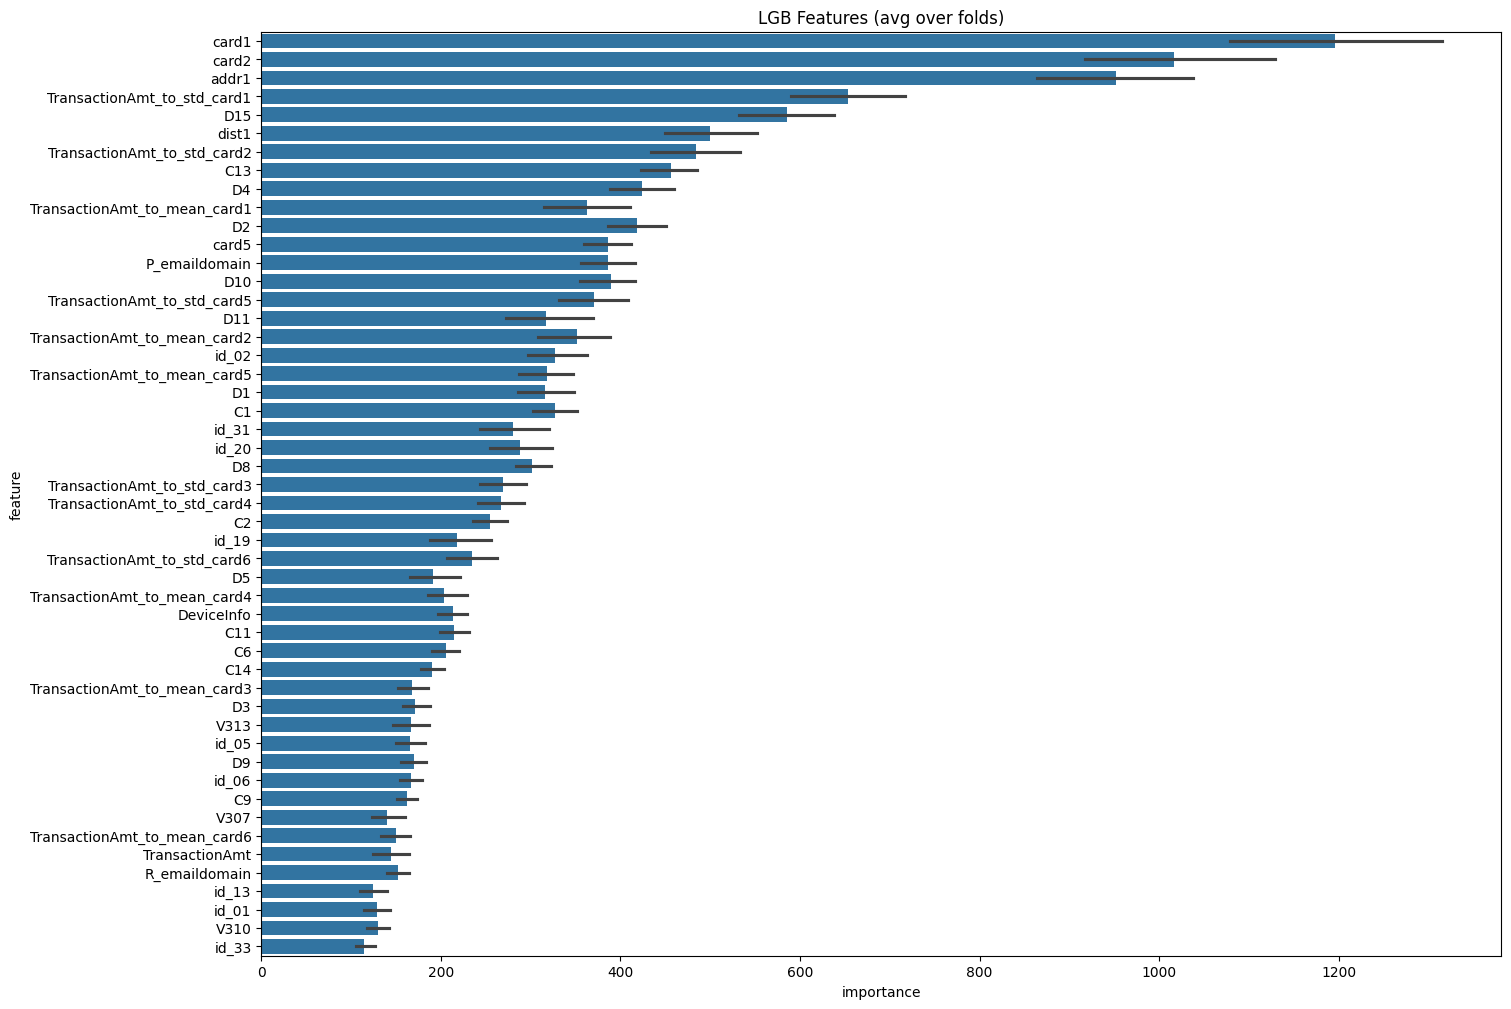

In [67]:
result_dict_lgb_kfold = train_model_classification(
    X=X,
    X_test=X_test,
    y=y,
    params=params,
    folds=folds_kfold,
    model_type="lgb",
    eval_metric="auc",
    plot_feature_importance=True,
    verbose=500,
    early_stopping_rounds=200,
    n_estimators=5000,
    averaging="usual",
    n_jobs=-1,
)

In [69]:
result_dict_lgb_time_series["top_columns"]

Index(['card1', 'card2', 'addr1', 'TransactionAmt_to_std_card1', 'D15',
       'TransactionAmt_to_std_card2', 'dist1', 'C13', 'D4', 'D10', 'D2',
       'card5', 'P_emaildomain', 'TransactionAmt_to_std_card5', 'id_02',
       'TransactionAmt_to_mean_card2', 'TransactionAmt_to_mean_card1', 'C1',
       'TransactionAmt_to_mean_card5', 'D8', 'D1', 'id_20',
       'TransactionAmt_to_std_card3', 'TransactionAmt_to_std_card4', 'C2',
       'D11', 'id_31', 'TransactionAmt_to_std_card6', 'C11', 'C6',
       'TransactionAmt_to_mean_card4', 'D5', 'C14', 'DeviceInfo', 'id_19',
       'D9', 'D3', 'V313', 'R_emaildomain', 'id_06',
       'TransactionAmt_to_mean_card3', 'id_05', 'C9', 'TransactionAmt',
       'id_01', 'V307', 'V310', 'TransactionAmt_to_mean_card6', 'id_33', 'M6'],
      dtype='object', name='feature')

In [130]:
result_dict_lgb_kfold["feature_importance"]

,feature,importance,fold
0,TransactionAmt,168.2,1
1,ProductCD,43.6,1
2,card1,1278.0,1
3,card2,1074.0,1
4,card3,75.2,1
...,...,...,...
362,P_emaildomain_2,37.0,5
363,P_emaildomain_3,14.0,5
364,R_emaildomain_1,13.8,5
365,R_emaildomain_2,9.6,5


In [ ]:
top_features = (
    result_dict_lgb_kfold["feature_importance"]
    .groupby("feature")["importance"]
    .agg("mean")
    .sort_values()[-100:]
    .reset_index()
)

In [145]:
top_features.to_csv(folder_path + "top_features.csv", index=False)

In [70]:
result_dict_lgb_kfold["top_columns"]

Index(['card1', 'card2', 'addr1', 'TransactionAmt_to_std_card1', 'D15',
       'dist1', 'TransactionAmt_to_std_card2', 'C13', 'D4', 'D2', 'D10',
       'card5', 'P_emaildomain', 'TransactionAmt_to_std_card5',
       'TransactionAmt_to_mean_card1', 'TransactionAmt_to_mean_card2', 'id_02',
       'C1', 'TransactionAmt_to_mean_card5', 'D11', 'D1', 'D8', 'id_20',
       'id_31', 'TransactionAmt_to_std_card3', 'TransactionAmt_to_std_card4',
       'C2', 'TransactionAmt_to_std_card6', 'id_19', 'C11', 'DeviceInfo', 'C6',
       'TransactionAmt_to_mean_card4', 'D5', 'C14', 'D3', 'D9',
       'TransactionAmt_to_mean_card3', 'V313', 'id_06', 'id_05', 'C9',
       'R_emaildomain', 'TransactionAmt_to_mean_card6', 'TransactionAmt',
       'V307', 'V310', 'id_01', 'id_13', 'id_33'],
      dtype='object', name='feature')

# save data

In [75]:
X.card4.isna().sum()

0

In [79]:
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card2,TransactionAmt_to_mean_card2,TransactionAmt_to_std_card3,TransactionAmt_to_mean_card3,TransactionAmt_to_std_card4,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card5,TransactionAmt_to_mean_card5,TransactionAmt_to_std_card6,TransactionAmt_to_mean_card6,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,68.50,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,117.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,117.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,55,28,3,2,127,568,547,2,2,86,136,6,461,4,2,2,2,2,2,2740,0.184566,0.194640,NaN,NaN,0.273001,0.467667,0.170233,0.257761,0.205289,0.357614,0.202121,0.360461,25,7,4,25,7,4
1,29.00,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2,2,2,0,1,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0

In [86]:
columns_with_na = X.isna().sum(axis=0)[X.isna().sum(axis=0) != 0].index

In [ ]:
len([col for col in columns_with_na if col[0] != "V"])

40

In [93]:
columns_with_na_with_V = [col for col in columns_with_na if col[0] == "V"]

In [ ]:
# will fillna by mean

columns_with_na_with_V

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V87',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V99',
 'V100',
 'V126',
 'V127',
 'V128',
 'V130',
 'V131',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 '

In [ ]:
X.loc[:, columns_with_na_with_V] = X.loc[:, columns_with_na_with_V].fillna(
    X.loc[:, columns_with_na_with_V].mean()
)
# on test also should fillna by train mean
X_test.loc[:, columns_with_na_with_V] = X_test.loc[:, columns_with_na_with_V].fillna(
    X.loc[:, columns_with_na_with_V].mean()
)

In [ ]:
columns_with_na_not_V = [col for col in columns_with_na if col[0] != "V"]

In [ ]:
# will fillna by 0
columns_with_na_not_V

['card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_09',
 'id_10',
 'id_11',
 'TransactionAmt_to_std_card1',
 'TransactionAmt_to_std_card2',
 'TransactionAmt_to_mean_card2',
 'TransactionAmt_to_std_card3',
 'TransactionAmt_to_mean_card3',
 'TransactionAmt_to_std_card4',
 'TransactionAmt_to_mean_card4',
 'TransactionAmt_to_std_card5',
 'TransactionAmt_to_mean_card5',
 'TransactionAmt_to_std_card6',
 'TransactionAmt_to_mean_card6']

In [ ]:
X.loc[:, columns_with_na_not_V] = X.loc[:, columns_with_na_not_V].fillna(0)
# on test also should fillna by train mean
X_test.loc[:, columns_with_na_not_V] = X_test.loc[:, columns_with_na_not_V].fillna(0)

In [101]:
X.isna().any().any()

False

In [103]:
X_test

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card2,TransactionAmt_to_mean_card2,TransactionAmt_to_std_card3,TransactionAmt_to_mean_card3,TransactionAmt_to_std_card4,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card5,TransactionAmt_to_mean_card5,TransactionAmt_to_std_card6,TransactionAmt_to_mean_card6,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,31.950,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,1.0,16,32,6.0,6.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,0.0,0.000000,0.000000,418.0,203.0,0.0,0.0,0.0,409.0,1,1,0,3,2,0,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,47.950001,0.000000,47.950001,0.000000,0.036439,1.073915,1.125267,0.037696,0.048581,8.397006,3.708484,22.112946,0.156276,0.168601,0.765001,0.775313,277.598028,6.46019,9.43271,0.7532,0.757423,0.767381,0.777485,0.817573,0.833461,2719.299775,47453.181173,4.843938,6.594661,5.505955,877.888928,2239.912219,359.469437,3.929514,5.859501,0.168053,1.436779,1.690908,0.132012,0.055231,0.127794,0.212639,1.376979,3.529245,6.649283,4.869012,0.924123,0.253332,0.856243,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.213083,1.058984,1.237361,1.149845,0.945773,0.954227,1.08458,0.949385,0.961951,1.270749,1.119977,1.159106,444.147142,1078.327538,686.956931,18.060417,6.18936,72.284098,8.888193,35.001872,14.391835,385.137037,765.988339,536.302802,38.437547,133.208217,71.107143,1.054619,1.725784,1.367132,0.169472,1.274912,1.359005,0.093153,0.394748,0.191758,0.247612,0.147975,1.351928,1.63871,1.465476,0.765506,1.005597,0.908388,2.092847,0.184106,0.307667,0.2535,0.127956,0.136965,1.000997,1.000238,1.113463,1.178387,1.118562,0.876619,1.183723,1.025355,1.069493,1.042851,0.788588,0.794231,1.032048,1.162164,1.075113,0.806656,0.81495,1.250993,1.34351,0.967832,0.964425,1.107161,1.013279,117.390676,201.657617,153.520534,9.167839,36.525103,18.813407,5.997508,7.712764,9.445133,

In [107]:
X_test.isna().sum()[X_test.isna().sum() > 0]

C1        3
C2        3
C4        3
C5        3
C6        3
C7        3
C8        3
C9        3
C10       3
C11       3
C12       3
C13    4748
C14       3
dtype: int64

In [109]:
X_test = X_test.fillna(0)

In [110]:
X_test.isna().any().any()

False

In [117]:
X_test.to_csv(folder_path + "X_test.csv", index=False)

In [118]:
X.to_csv(folder_path + "X.csv", index=False)

In [119]:
X_test

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card2,TransactionAmt_to_mean_card2,TransactionAmt_to_std_card3,TransactionAmt_to_mean_card3,TransactionAmt_to_std_card4,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card5,TransactionAmt_to_mean_card5,TransactionAmt_to_std_card6,TransactionAmt_to_mean_card6,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,31.950,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,1.0,16,32,6.0,6.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,0.0,0.000000,0.000000,418.0,203.0,0.0,0.0,0.0,409.0,1,1,0,3,2,0,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,47.950001,0.000000,47.950001,0.000000,0.036439,1.073915,1.125267,0.037696,0.048581,8.397006,3.708484,22.112946,0.156276,0.168601,0.765001,0.775313,277.598028,6.46019,9.43271,0.7532,0.757423,0.767381,0.777485,0.817573,0.833461,2719.299775,47453.181173,4.843938,6.594661,5.505955,877.888928,2239.912219,359.469437,3.929514,5.859501,0.168053,1.436779,1.690908,0.132012,0.055231,0.127794,0.212639,1.376979,3.529245,6.649283,4.869012,0.924123,0.253332,0.856243,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.213083,1.058984,1.237361,1.149845,0.945773,0.954227,1.08458,0.949385,0.961951,1.270749,1.119977,1.159106,444.147142,1078.327538,686.956931,18.060417,6.18936,72.284098,8.888193,35.001872,14.391835,385.137037,765.988339,536.302802,38.437547,133.208217,71.107143,1.054619,1.725784,1.367132,0.169472,1.274912,1.359005,0.093153,0.394748,0.191758,0.247612,0.147975,1.351928,1.63871,1.465476,0.765506,1.005597,0.908388,2.092847,0.184106,0.307667,0.2535,0.127956,0.136965,1.000997,1.000238,1.113463,1.178387,1.118562,0.876619,1.183723,1.025355,1.069493,1.042851,0.788588,0.794231,1.032048,1.162164,1.075113,0.806656,0.81495,1.250993,1.34351,0.967832,0.964425,1.107161,1.013279,117.390676,201.657617,153.520534,9.167839,36.525103,18.813407,5.997508,7.712764,9.445133,

In [120]:
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card2,TransactionAmt_to_mean_card2,TransactionAmt_to_std_card3,TransactionAmt_to_mean_card3,TransactionAmt_to_std_card4,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card5,TransactionAmt_to_mean_card5,TransactionAmt_to_std_card6,TransactionAmt_to_mean_card6,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,68.50,4,13926,0.0,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.542594,0.579198,1.108065,1.1624,0.166076,0.177145,0.999269,0.156118,0.168942,1.083891,1.120779,1.022286,1.038515,0.383174,0.397724,0.164746,0.170579,0.182695,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,117.000000,0.000000,0.000000,0.0,0.036439,1.073915,1.125267,0.037696,0.048581,8.397006,3.708484,22.112946,0.156276,0.168601,0.765001,0.775313,277.598028,6.46019,9.43271,0.7532,0.757423,0.767381,0.777485,0.817573,0.833461,2719.299775,47453.181173,4.843938,6.594661,5.505955,877.888928,2239.912219,359.469437,3.929514,5.859501,0.168053,1.436779,1.690908,0.132012,0.055231,0.127794,0.212639,1.376979,3.529245,6.649283,4.869012,0.924123,0.253332,0.856243,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.213083,1.058984,1.237361,1.149845,0.945773,0.954227,1.08458,0.949385,0.961951,1.270749,1.119977,1.159106,444.147142,1078.327538,686.956931,18.060417,6.18936,72.284098,8.888193,35.001872,14.391835,385.137037,765.988339,536.302802,38.437547,133.208217,71.107143,1.054619,1.725784,1.367132,0.169472,1.274912,1.359005,0.093153,0.394748,0.191758,0.247612,0.147975,1.351928,1.63871,1.465476,0.765506,1.005597,0.908388,2.092847,0.184106,0.307667,0.2535,0.127956,0.136

In [121]:
y.to_csv(folder_path + "target_train.csv", index=False)